In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, LSTM, Embedding, Concatenate, Reshape, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

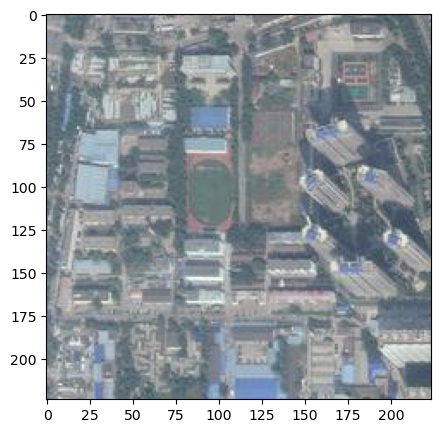

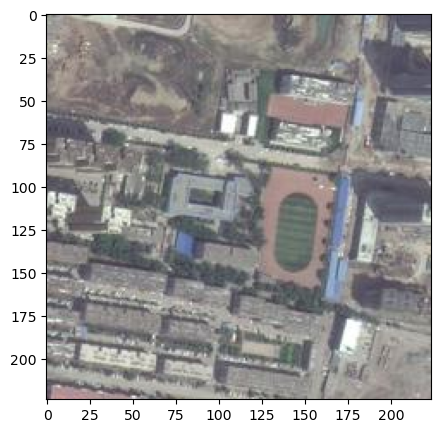

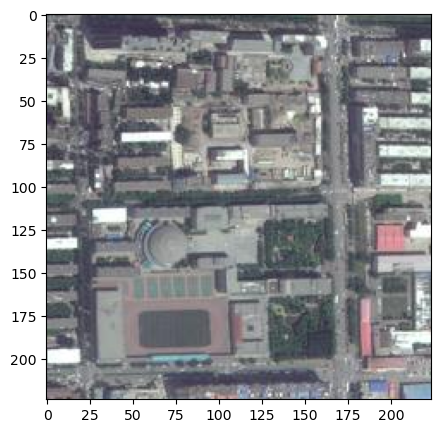

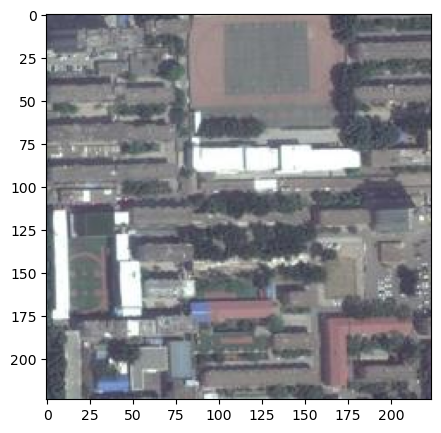

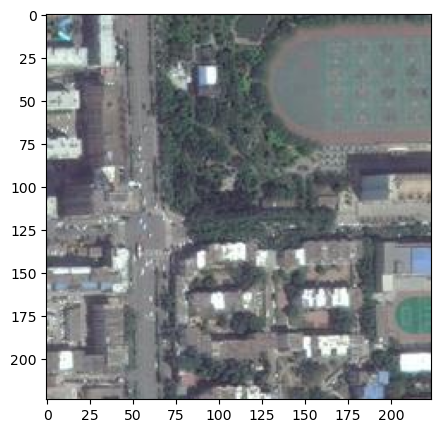

In [3]:
# Load images
img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images"
images = glob(img_path + '\\*.jpg')

# Load captions
captions = open(r"C:\Users\SRAVAN\Downloads\outcap.txt", 'rb').read().decode('utf-8').split('\n')
captions = [line.replace('\r', '') for line in captions]

# Display sample images
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Load ResNet50 model
resnet_model = ResNet50(include_top=True, weights='imagenet')

# Remove classification layer
resnet_features_model = Model(inputs=resnet_model.input, outputs=resnet_model.layers[-2].output)


In [5]:
# Extract image features using MobileNetV2
count=0
img_features = {}
for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) 
    img = img.reshape(1,224,224,3) 
    features = resnet_features_model.predict(img).reshape(-1,) 
    img_name = img_path.split('/')[-1] 
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images as using more than 1500 images leads to overloading memory issues
    if count == 1500:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/10921 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [6]:
len(img_features)

1500

In [7]:
captions = captions[1:]
captions[:5]

['00001.jpg,a football field with several buildiings surroudned .',
 '00001.jpg,a rectangular playground and many tall buildings surrounded .',
 '00001.jpg,many buildings and green trees are around a playground .',
 '00001.jpg,many buildings are in different blocks with many green trees and a playground .',
 '00001.jpg,a playground is surrounded by many trees and buildings .']

In [8]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        img_name = "C:\\Users\\SRAVAN\\Downloads\\RSICD_images\\RSICD_images\\" + img_name # Adding the prefix
        caption = cap.split(',')[1]
        
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions 
    except:
        break

print(len(captions_dict))


1500


In [9]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [10]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

In [11]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [12]:
len(count_words) # Vocab size

1234

In [13]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [14]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [15]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

1234

In [16]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [17]:
X, y_in, y_out = generator(img_features,captions_dict)

In [18]:
len(X), len(y_in), len(y_out)

(96207, 96207, 96207)

In [19]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [20]:
X.shape, y_in.shape, y_out.shape

((96207, 2048), (96207, 35), (96207, 1235))

In [23]:
from keras.layers import Layer, Input, Dense, Embedding, LSTM, Dropout, Concatenate, Reshape, Add, Bidirectional
from keras.models import Model

class CaptionsModel(Layer):
    def __init__(self, vocab_size, embedding_len, max_len):
        super(CaptionsModel, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_len, mask_zero=False)
        self.bilstm = Bidirectional(LSTM(256))
        self.vocab_size = vocab_size

    def call(self, inputs):
        img_features, sentence_features = inputs
        embeddings = self.embedding(sentence_features)
        img_features_expanded = Reshape((1, 256))(img_features)
        merged = Concatenate(axis=1)([img_features_expanded, embeddings])
        bilstm_output = self.bilstm(merged)
        return bilstm_output

# Given parameters
vocab_size = 1235
max_length = 35
embedding_len = 256

# Inputs
input1 = Input(shape=(2048,))  # Image features
input2 = Input(shape=(max_length,))  # Caption sequence

# Image features processing
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)

# Caption model
captions_model = CaptionsModel(vocab_size, embedding_len, max_length)
sentence_features = captions_model([img_features_reshaped, input2])

# Dropout
x = Dropout(0.5)(sentence_features)

# Reshape img_features to match the dimension
img_features_resized = Dense(512, activation='relu')(img_features)

# Add layers
x = Add()([x, img_features_resized])

# Further processing
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(units=vocab_size, activation='softmax')(x)

# Model
final_model = Model(inputs=[input1, input2], outputs=output)
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │         524,544 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_2 (Reshape)           │ (None, 1, 256)            │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ captions_model_2              │ (None, 512)               │       1,366,784 │ reshape_2[0][0],           │
│ (CaptionsModel)               │                           │                 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 512)               │               0 │ captions_model_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 512)               │         131,584 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 512)               │               0 │ dropout_2[0][0],           │
│                               │                           │                 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 128)               │          65,664 │ add_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 128)               │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 1235)              │         159,315 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,247,891 (8.58 MB)

 Trainable params: 2,247,891 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from sklearn.model_selection import train_test_split

# Splitting data into train, validation, and test sets
X_train, X_temp, y_in_train, y_in_temp, y_out_train, y_out_temp = train_test_split(X, y_in, y_out, test_size=0.4, random_state=42)
X_val, X_test, y_in_val, y_in_test, y_out_val, y_out_test = train_test_split(X_temp, y_in_temp, y_out_temp, test_size=0.5, random_state=42)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define ModelCheckpoint callback to save the best model based on validation accuracy
mc2 = ModelCheckpoint(r"C:\Users\SRAVAN\Downloads\resnet1_50.keras", monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Compile the model with accuracy metric
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model with EarlyStopping callback
history = final_model.fit([X_train, y_in_train],
                          y_out_train,
                          batch_size=512,
                          callbacks=[mc2, early_stopper],
                          epochs=50,
                          validation_data=([X_val, y_in_val], y_out_val))

# Print loss, validation loss, and validation accuracy for each epoch
for epoch, metrics in enumerate(zip(history.history['loss'], history.history['val_loss'], history.history['val_accuracy'])):
    print(f"Epoch {epoch + 1}: loss: {metrics[0]:.4f} - val_loss: {metrics[1]:.4f} - val_accuracy: {metrics[2]:.4f}")


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.0922 - loss: 5.0686
Epoch 1: val_accuracy improved from -inf to 0.23549, saving model to C:\Users\SRAVAN\Downloads\resnet1_50.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.0926 - loss: 5.0622 - val_accuracy: 0.2355 - val_loss: 3.5481
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.2430 - loss: 3.5398
Epoch 2: val_accuracy improved from 0.23549 to 0.39114, saving model to C:\Users\SRAVAN\Downloads\resnet1_50.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 103s 906ms/step - accuracy: 0.2433 - loss: 3.5379 - val_accuracy: 0.3911 - val_loss: 2.7508
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.3921 - loss: 2.7588
Epoch 3: val_accuracy improved from 0.39114 to 0.50761, saving model to C:\Users\SRAVAN\Downloads\resnet1_50.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 105s 931ms/step - accuracy: 0.3923 - loss: 2.7578 - val_accuracy: 0.5076 - val_loss: 2.2397
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━

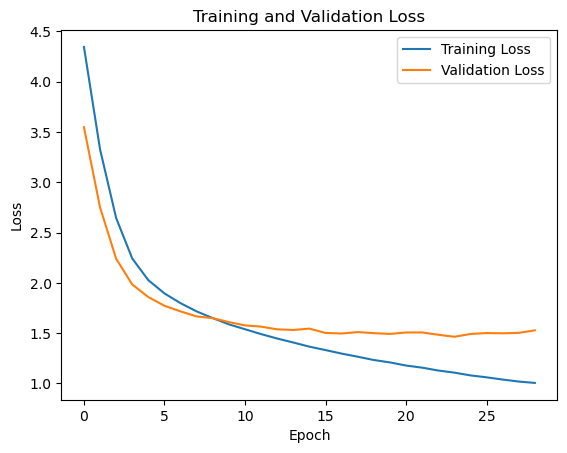

In [27]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Extracting training metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracting validation metrics
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Evaluating metrics on test set
test_loss, test_accuracy = final_model.evaluate([X_test, y_in_test], y_out_test, verbose=0)

# Printing metrics
print("Train Accuracy:", train_accuracy[-1])
print("Train Loss:", train_loss[-1])
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)
print("Validation Accuracy:", val_accuracy[-1])
print("Validation Loss:", val_loss[-1])

Train Accuracy: 0.7223338484764099
Train Loss: 1.0055488348007202
Test Accuracy: 0.687038779258728
Test Loss: 1.47385573387146
Validation Accuracy: 0.6999116539955139
Validation Loss: 1.528468132019043


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Make predictions on the test set
y_pred = final_model.predict([X_test, y_in_test])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_out_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
# Print evaluation metrics
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

602/602 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step
Test Accuracy: 0.687038779258728
Precision: 0.8147823392354311
Recall: 0.183651730259104
F1 Score: 0.15480535719209795


In [30]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

In [31]:
final_model.save('resnet1_50.keras')

In [32]:
np.save('vocab.npy',count_words)

In [33]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Caption: many planes are parked in an airport .
Best Real Caption: many planes are parked in an airport near a parking lot .
Best BLEU-1 score: 60.653065971263345
Best BLEU-2 score: 56.15382758902617
Best BLEU-3 score: 54.21799008615763
Best BLEU-4 score: 52.734307450329375


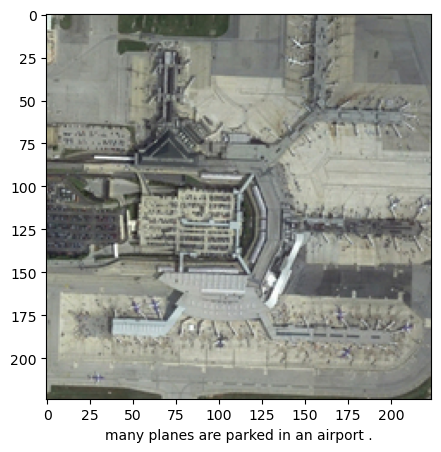

ROUGE Scores: {'rouge1': Score(precision=1.0, recall=0.6363636363636364, fmeasure=0.7777777777777778), 'rouge2': Score(precision=1.0, recall=0.6, fmeasure=0.7499999999999999), 'rougeL': Score(precision=1.0, recall=0.6363636363636364, fmeasure=0.7777777777777778)}
METEOR score: 68.42672413793103


In [42]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Concatenate, Dropout, Reshape, add
from keras.models import Model
import numpy as np
import cv2
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

def read_captions(file_path, image_name):
    """Read captions from a file for a given image."""
    with open(file_path, 'r') as file:
        captions = [line.strip().split(',', 1)[1] for line in file if line.startswith(image_name)]
    return captions

# Test image path
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\airport_99.jpg"
image_name = test_img_path.split('\\')[-1]

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly
    exit()

# Load the image using the getImage function and image_index
test_feature = resnet_features_model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words.get(word, 0) for word in pred_text]  # Handle unknown words with .get()
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict.get(pred_idx, '')  # Handle unknown indices with .get()
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Read the real captions from the dataset file
dataset_path = r"C:\Users\SRAVAN\Downloads\outcap.txt"
real_captions = read_captions(dataset_path, image_name)

# Tokenize the predicted caption
pred_tokens = word_tokenize(caption.strip())

# Initialize variables for the best caption and its BLEU scores
best_caption = ""
best_bleu1_score = 0
best_bleu2_score = 0
best_bleu3_score = 0
best_bleu4_score = 0

# Calculate BLEU scores for each real caption and find the best one
for real_caption in real_captions:
    real_tokens = word_tokenize(real_caption)
    
    # Calculate BLEU scores
    score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
    score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
    score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
    score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    
    # Update the best caption if the current BLEU scores are higher
    if score_bleu1 > best_bleu1_score:
        best_bleu1_score = score_bleu1
    if score_bleu2 > best_bleu2_score:
        best_bleu2_score = score_bleu2
    if score_bleu3 > best_bleu3_score:
        best_bleu3_score = score_bleu3
    if score_bleu4 > best_bleu4_score:
        best_bleu4_score = score_bleu4
        best_caption = real_caption
print(f"Predicted Caption: {caption.strip()}")
# Print the best real caption and its BLEU scores
print(f"Best Real Caption: {best_caption}")
print(f"Best BLEU-1 score: {best_bleu1_score * 100}")
print(f"Best BLEU-2 score: {best_bleu2_score * 100}")
print(f"Best BLEU-3 score: {best_bleu3_score * 100}")
print(f"Best BLEU-4 score: {best_bleu4_score * 100}")

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption.strip())  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for the best caption
scores_rouge = scorer.score(best_caption, caption.strip())

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score for the best caption
score_meteor = meteor_score([word_tokenize(best_caption)], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
BLEU-1 score: 25.0
BLEU-2 score: 15.075567228888179
BLEU-3 score: 7.96704465984818e-102
BLEU-4 score: 5.791739854583281e-153
Real Caption: some trees are planted on the beach .
Predicted Caption:  a large number of cars in the airport on the bareland .


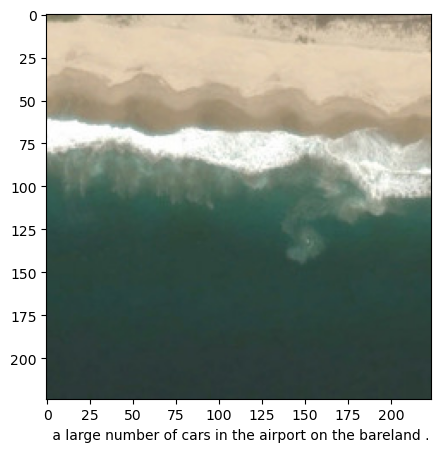

ROUGE Scores: {'rouge1': Score(precision=0.18181818181818182, recall=0.2857142857142857, fmeasure=0.2222222222222222), 'rouge2': Score(precision=0.1, recall=0.16666666666666666, fmeasure=0.125), 'rougeL': Score(precision=0.18181818181818182, recall=0.2857142857142857, fmeasure=0.2222222222222222)}
METEOR score: 30.423280423280424


In [38]:

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path =r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\beach_37.jpg"# Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = resnet_features_model.predict(getImage(image_index)).reshape(1, 2048)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\SRAVAN\Downloads\outcap.txt", "beach_37")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")


In [1]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import cv2
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize lists to store BLEU, METEOR, and ROUGE scores for each image
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
meteor_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Define the total number of images to be processed
total_images = 1500

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i in range(total_images):
    print(f"Processing image {i + 1}/{total_images}")

    # Test image path
    test_img_path = images[i]
    image_name = test_img_path.split('\\')[-1]

    # Find the index of the test_img_path in the images list
    try:
        image_index = images.index(test_img_path)
    except ValueError:
        print(f"Image path '{test_img_path}' not found in the images list.")
        continue  # Skip to the next image if not found

    # Load the image using the getImage function and image_index
    test_feature = resnet_features_model.predict(getImage(image_index)).reshape(1, 2048)

    # Load and preprocess the image using OpenCV
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Initialize the caption generation process
    pred_text = ['startofseq']
    count = 0
    caption = ''  # Stores the predicted captions text

    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = [count_words.get(word, 0) for word in pred_text]  # Handle unknown words with .get()

        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')

        # Fetching the predicted word index
        pred_idx = np.argmax(final_model.predict([test_feature, encoded]))

        # Extracting the predicted word by its respective index
        sampled_word = inverse_dict.get(pred_idx, '')  # Handle unknown indices with .get()

        # Checking for ending of the sequence
        if (sampled_word == 'endofseq'):
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)

    # Read the real captions from the dataset file
    real_captions = read_captions(dataset_path, image_name)

    # Initialize variables for the best caption and its BLEU scores
    best_bleu1_score = 0
    best_bleu2_score = 0
    best_bleu3_score = 0
    best_bleu4_score = 0
    best_meteor_score = 0
    best_rouge1_score = 0
    best_rouge2_score = 0
    best_rougeL_score = 0

    # Calculate BLEU, METEOR, and ROUGE scores for each real caption and find the best ones
    for real_caption in real_captions:
        real_tokens = word_tokenize(real_caption)
        pred_tokens = word_tokenize(caption.strip())

        # Calculate BLEU scores
        score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
        score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
        score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
        score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

        # Update the best BLEU scores if the current scores are higher
        best_bleu1_score = max(best_bleu1_score, score_bleu1)
        best_bleu2_score = max(best_bleu2_score, score_bleu2)
        best_bleu3_score = max(best_bleu3_score, score_bleu3)
        best_bleu4_score = max(best_bleu4_score, score_bleu4)

        # Calculate METEOR score
        score_meteor = meteor_score([word_tokenize(real_caption)], word_tokenize(caption.strip()))
        best_meteor_score = max(best_meteor_score, score_meteor)

        # Calculate ROUGE scores
        scores_rouge = scorer.score(real_caption, caption.strip())
        best_rouge1_score = max(best_rouge1_score, scores_rouge['rouge1'].fmeasure)
        best_rouge2_score = max(best_rouge2_score, scores_rouge['rouge2'].fmeasure)
        best_rougeL_score = max(best_rougeL_score, scores_rouge['rougeL'].fmeasure)

    # Store the best BLEU, METEOR, and ROUGE scores for this image
    bleu1_scores.append(best_bleu1_score)
    bleu2_scores.append(best_bleu2_score)
    bleu3_scores.append(best_bleu3_score)
    bleu4_scores.append(best_bleu4_score)
    meteor_scores.append(best_meteor_score)
    rouge1_scores.append(best_rouge1_score)
    rouge2_scores.append(best_rouge2_score)
    rougeL_scores.append(best_rougeL_score)

# Calculate average BLEU, METEOR, and ROUGE scores
avg_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
avg_bleu2 = sum(bleu2_scores) / len(bleu2_scores)
avg_bleu3 = sum(bleu3_scores) / len(bleu3_scores)
avg_bleu4 = sum(bleu4_scores) / len(bleu4_scores)
avg_meteor = sum(meteor_scores) / len(meteor_scores)
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# Print average BLEU, METEOR, and ROUGE scores
print(f"Average BLEU-1 score: {avg_bleu1 * 100}")
print(f"Average BLEU-2 score: {avg_bleu2 * 100}")
print(f"Average BLEU-3 score: {avg_bleu3 * 100}")
print(f"Average BLEU-4 score: {avg_bleu4 * 100}")
print(f"Average METEOR score: {avg_meteor * 100}")
print(f"Average ROUGE-1 score: {avg_rouge1 * 100}")
print(f"Average ROUGE-2 score: {avg_rouge2 * 100}")
print(f"Average ROUGE-L score: {avg_rougeL * 100}")

# Combine the scores into an overall average score (assuming equal weights for simplicity)
combined_score = (avg_bleu1 + avg_bleu2 + avg_bleu3 + avg_bleu4 + avg_meteor + avg_rouge1 + avg_rouge2 + avg_rougeL) / 8

# Print the combined average score
print(f"Combined Average Score: {combined_score * 100}")


KeyboardInterrupt: 